# Learning leaves a memory trace in motor cortex
Darby M. Losey, Jay A. Hennig+, Emily R. Oby+, Matthew D. Golub, Patrick T. Sadtler, Kristin M. Quick, Stephen I. Ryu,Elizabeth C. Tyler-Kabara, Aaron P. Batista*, Byron M. Yu*, Steven M. Chase*
+,* denotes equal contribution

Companion code for the manuscript "Learning leaves a memory trace in motor cortex", Current Biology, in press.

Code is authored by Darby Losey.

In [1]:
import scipy
import random
import collections
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mt_functions as h

mm = 1 / 25.4 # constant for converting inches to mms.
lat_names = [f'qlat{ii}' for ii in range(10)] # column names of orthonormalized latent factors

# Figure 1

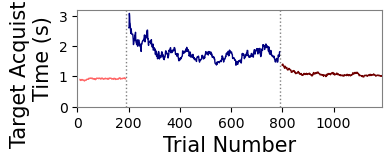

In [2]:
fig1_acq_times_df = h.load_pickle('./data/fig1') # Load acquisition times
f, ax = plt.subplots(1, 1, figsize=(100 * mm, 32 * mm))
for task in ['FamTask1', 'NewTask', 'FamTask2']:
    task_df = fig1_acq_times_df.xs(task)
    x = task_df.index.get_level_values('trial_index').values
    y = task_df.acq_time.values
    y_smooth = h.causal_smooth(y, window_size=25, window_function='box', trim_front=8, nan_start=False)
    if task in {'FamTask1', 'NewTask'}: ax.axvline(x[-1], color='grey', linestyle=':', linewidth=1)
    ax.plot(x, y_smooth, color=h.task_to_color(task), linewidth=1, solid_capstyle='butt')
ax.set_xlabel('Trial Number', fontsize=15)
ax.set_ylim(0, 3.2)
ax.set_xlim(0, len(fig1_acq_times_df))
h.set_tick_locations([0, 1, 2, 3], 'y')
h.set_tick_locations([0, 200, 400, 600, 800, 1000], 'x')
ax.set_ylabel('Target Acquistion\nTime (s)', fontsize=15)
for spine in ax.spines.values(): spine.set_edgecolor('grey')

# Figure 3

In [3]:
# load data for figure 3
fig3_session_str, fig3_tar, fig3_df = h.load_pickle('./data/fig3')

## Figure 3a

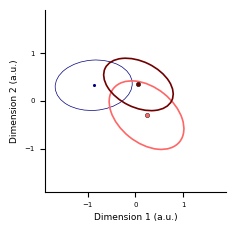

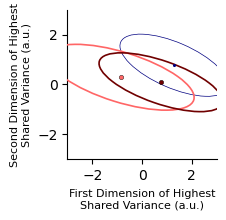

In [4]:
def plot_fig3(X_lda, y, rotate_by):
    """
    Plots a figure with linear discriminant analysis (LDA) transformed data, optionally rotated, 
    and visualizes covariance ellipses for different task types.

    Parameters:
    - X_lda (np.ndarray): The LDA-transformed data.
    - y (np.ndarray): The labels corresponding to the data points in `X_lda`, indicating the block type.
    - rotate_by (float or None): The angle by which to rotate the data points and ellipses, in degrees. 
                                 If `None`, no rotation is applied.
    """
    for ii, block_type in enumerate(['NewTask', 'FamTask1', 'FamTask2']):
        x1 = X_lda[:, 0][y == block_type]
        x2 = X_lda[:, 1][y == block_type]
        xx = np.concatenate([x1[:, np.newaxis], x2[:, np.newaxis]], axis=1)
        if rotate_by is not None: x1, x2 = h.rotate((0, 0), xx, rotate_by, flipy=False)
        color = h.block_type_to_color(block_type)
        if block_type in ['FamTask1', 'FamTask2']: lw, s, center_lw = 1.2, 10, 0.3
        else: lw, s, center_lw = 0.5, 5, 0
        h.plot_covar_ellipse(ax, x1, x2, linewidth=lw,color=color, show_mean=False, invis_scatter=False)
        plt.scatter(np.mean(x1), np.mean(x2), alpha=1, color=h.block_type_to_color(block_type), edgecolors='k', linewidth=center_lw, s=s, zorder=999)
    h.hide_spine(ax=ax, tblr='tr')

def lda_fig(ab_pd, ax, rotate_by=None):
    """
    Performs Linear Discriminant Analysis (LDA) on given data and plots the resulting LDA-transformed data.

    Parameters:
    - ab_pd (pd.DataFrame): DataFrame containing the data and block types. The data should be in columns specified by `lat_names`.
    - ax (matplotlib.axes.Axes): The axes object on which the LDA plot will be drawn.
    - rotate_by (float or None, optional): The angle in degrees by which the data points and ellipses should be rotated. If `None`, no rotation is applied.

    Returns:
    - tuple: Contains the eigenvalues from LDA (`evals`), the original transformation matrix (`W`), the orthonormalized transformation matrix (`q`), the matrix `r` from QR decomposition, and the centered data (`X_centered`).
    """

    X = ab_pd[lat_names].values
    y = ab_pd.block_type.values
    assert X.shape[1] == 10
    evals, W = h.calc_lda(X, y)
    X_centered = X - np.mean(X, axis=0)
    q, r = np.linalg.qr(W)  # orthonormalize q
    X_lda = X_centered @ q
    plot_fig3(X_lda, y, rotate_by)
    return evals, W, q, r, X_centered

# Figure 3a
f, ax = plt.subplots(1, 1, figsize=(60 * mm, 60 * mm))
evals, W, q, r, X_centered = lda_fig(fig3_df, ax=ax, rotate_by=340)
h.set_tick_locations(ax=ax, xy='xy', locations=np.arange(-2, 2.1, 1))
ax.set_aspect('equal')
ax.set_xlim([-1.9, 1.9])
ax.set_ylim([-1.9, 1.9])
ax.set_xlabel('Dimension 1 (a.u.)', fontsize=8)
ax.set_ylabel('Dimension 2 (a.u.)', fontsize=8)
h.set_standard_fonts(ax)

# Figure S3a
f, ax = plt.subplots(1, 1, figsize=(60 * mm, 60 * mm))
plot_fig3(fig3_df[lat_names[:2]].values, fig3_df.block_type, rotate_by=None)
ax.set_aspect('equal')
lim = 3
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
ax.set_xlabel('First Dimension of Highest\nShared Variance (a.u.)', fontsize=8)
_ = ax.set_ylabel('Second Dimension of Highest\nShared Variance (a.u.)', fontsize=8)
plt.tight_layout()

## Figure 3b

In [5]:
def calc_pop_dist(lats, block_types):
    """
    Calculates the Mahalanobis distance between two populations of data, representing two different tasks.

    Parameters:
    - lats (pd.DataFrame or np.ndarray): The latency values for the two tasks. Each row corresponds to an observation, and each column corresponds to a variable.
    - block_types (np.ndarray or pd.Series): Array or series indicating the block type ('FamTask1' or 'FamTask2') for each observation in `lats`.

    Returns:
    - float: The Mahalanobis distance between the two tasks, indicating the dissimilarity in their means adjusted for the covariance.
    """
    task1_lats = lats.values[block_types == 'FamTask1'].T
    task2_lats = lats.values[block_types == 'FamTask2'].T
    cov = np.cov(task1_lats)
    diff = task1_lats.mean(axis=1) - task2_lats.mean(axis=1)
    return h.calc_mahalanobis(cov, diff)

pop_distance         = calc_pop_dist(fig3_df[lat_names], fig3_df.block_type) # Data
control_block_labels = h.permute_subset(fig3_df.block_type, ['FamTask1', 'FamTask2']) # Control
ctrl_distance        = calc_pop_dist(fig3_df[lat_names], control_block_labels) # Control

print(f'Figure 3 Example ({fig3_session_str}-Target {fig3_tar})')
print('\tPopulation Distance:\t', np.round(pop_distance, 2),  'a.u.', 
      '\n\tControl Distance:\t' , np.round(ctrl_distance, 2), 'a.u.')

Figure 3 Example (J20120601-Target 270)
	Population Distance:	 0.91 a.u. 
	Control Distance:	 0.18 a.u.


# Figure 4

In [6]:
# Load data for figure 4
(example_session_str_fig4, example_target_fig4, fig4a_df, fig4_FamTask1_example_trial, 
fig4_NewTaskEarly_example_trial, fig4_NewTaskLate_example_trial, fig4_FamTask2_example_trial,  
fig4b_df, tar_pos, mt_values) = h.load_pickle('./data/fig4')

## Figure 4a

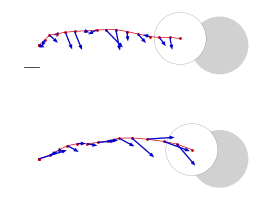

In [7]:
def main_fig4a(fig4a_df, target_angle, plot_NewTasks, tar_pos):
    # Constants
    cursor_radius_mm = 18
    target_radius_mm = 20
    velocity_scale   = 1/7

    # Create subplots
    f, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(70*mm, 70*mm))
    axes[0].plot([-10, 0], [-15, -15], color='k', linewidth=0.5)
    
    # Determine trial indexes
    trial_indexes = [201, 782] if plot_NewTasks else [4, 880]

    # Rotation matrix for transforming coordinates
    rotation_matrix = h.calc_rotation_matrix(-target_angle).T

    for idx, (trial_index, ax) in enumerate(zip(trial_indexes, axes)):
        ax.set_aspect('equal')
        
        # Filter data for the current trial
        trial_data = fig4a_df[fig4a_df.trial_index == trial_index]
        
        # Calculate and plot target position
        ax.add_artist(plt.Circle(tar_pos @ rotation_matrix, target_radius_mm, facecolor='#d1d1d1', zorder=50))
        
        # Process position data
        x_struct, y_struct = h.fig4_rotate_data(trial_data, ['posX_struct', 'posY_struct'], rotation_matrix)
        x_prev, y_prev = h.fig4_rotate_data(trial_data, ['posX_prev', 'posY_prev'], rotation_matrix)

        # Determine velocity mapping
        velocity_columns = ['M2FamMap_velX', 'M2FamMap_velY'] if plot_NewTasks else ['M2NewMap_velX', 'M2NewMap_velY']
        vel_xs, vel_ys = h.fig4_rotate_data(trial_data, velocity_columns, rotation_matrix)

        # Plotting
        h.fig4_plot_trajectory(ax, x_struct, y_struct, h.map_to_color, 'NewMap' if plot_NewTasks else 'FamMap')
        h.fig4_plot_velocity_vectors(ax, x_prev, y_prev, vel_xs, vel_ys, h.map_to_color, 'FamMap' if plot_NewTasks else 'NewMap', velocity_scale)
        h.fig4_set_plot_limits(ax, plot_NewTasks)

        # Plot cursor position
        ax.add_artist(plt.Circle([x_struct[-1], y_struct[-1]], cursor_radius_mm, facecolor='#FFFFFF', edgecolor='k', zorder=50, linewidth=0.1))

        # Hide spines and tick marks
        h.hide_spine(tblr='trlb', ax=ax)
        h.hide_tick_marks_and_labels(ax=ax, xy='xy')

    plt.tight_layout()
    h.set_standard_fonts(axes)

main_fig4a(fig4a_df, 225, plot_NewTasks=False, tar_pos=tar_pos)

Figure 3b FamMap, Sign Rank, p=0.426018012706617, n_famtask1=23, n_famtask2=19
Figure 3b NewMap, Sign Rank, p=0.007674849283595781, n_famtask1=23, n_famtask2=19


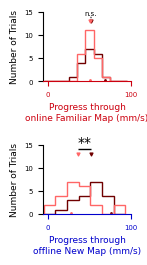

In [8]:
def create_fig4b(plot_newtask):
    """
    Create and display Figure 3b with plots for familiar and new tasks based on a given dataset.

    Parameters:
    - plot_newtask (bool): Flag to indicate whether to plot the new task. If False, creates Fig. 4b and Fig. 4c. 
                           If True, Fig. S4b and S4C
    """
    # Extract example trial data for familiar tasks from a larger dataset
    FamTask1_example_trial = fig4b_df[fig4b_df.trial_index == fig4_FamTask1_example_trial]
    FamTask2_example_trial = fig4b_df[fig4b_df.trial_index == fig4_FamTask2_example_trial]

    # Calculate means for different blocks and trials
    fig_4b_means = fig4b_df.groupby(['block_type', 'trial_index']).mean()

    # Create subplots for each map type
    f, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(40 * mm, 70 * mm))
    for ax, map_type, bins in zip(axes, ['FamMap', 'NewMap'], h.fig4b_get_bins(plot_newtask)):
        # Extract progress data for each task and map type
        famtask1_prog = fig_4b_means.xs('FamTask1')[f'M2{map_type}_cprog']
        newtask_prog  = fig_4b_means.xs('NewTask')[f'M2{map_type}_cprog']
        famtask2_prog = fig_4b_means.xs('FamTask2')[f'M2{map_type}_cprog']
        
        # Perform statistical analysis and print results
        _, pval = scipy.stats.ranksums(famtask2_prog, famtask1_prog)
        print(f'Figure 3b {map_type}, Sign Rank, p={pval}, n_famtask1={len(famtask1_prog)}, n_famtask2={len(famtask2_prog)}')
        # Plot the data on the axis
        h.fig4b_plot(ax, famtask1_prog, famtask2_prog, pval=pval,
                   famtask1_example_trial=FamTask1_example_trial[f'M2{map_type}_cprog'], 
                   famtask2_example_trial=FamTask2_example_trial[f'M2{map_type}_cprog'],
                   bins=bins, map_type=map_type, plot_newtask=plot_newtask, newtask_prog=newtask_prog)
    plt.tight_layout()
create_fig4b(plot_newtask=False)

## Figure 4

Wilcoxon, Monkey J, p=0.0001574652048556358, n=176, t=5230.0
Wilcoxon, Monkey N, p=1.9917619708416433e-06, n=96, t=1027.0
Wilcoxon, Monkey L, p=0.6095862779758816, n=72, t=1223.0


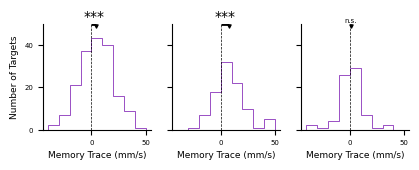

In [9]:
def calculate_bins(mt_values):
    """ Calculate bins for the histogram. """
    bin_width = 10
    values = []
    for mi in ['J', 'N', 'L']: values += mt_values[mi]
    return h.calc_zero_centered_hist_bins(values, bin_width)

def plot_memtrace(memory_trace_values, ax, bins, top_data_lim, pval):
    """
    Plot a the memory trace values for a given monkey.

    Parameters:
        memory_trace_values (array): The values to plot.
        ax (matplotlib.axes.Axes): The axis to plot on.
        bins (array): Bins for the histogram.
        top_data_lim (int): The upper limit for the data.
        pval (float): The p-value for statistical significance.
    """
    ax.hist(memory_trace_values, color='#7208acff', bins=bins, edgecolor='#7208acff', linewidth=0.5, histtype='step')
    h.hide_spine(ax=ax, tblr='tr')
    mean = np.nanmean(memory_trace_values)
    h.plot_bar_with_stars(mean, top_data_lim, pval, ax=ax)
    ax.scatter([mean], [top_data_lim - 1], color='k', marker='v', s=5)
    ax.plot([0, 0], [0, top_data_lim], color='k', linestyle='--', linewidth=0.5, solid_capstyle='butt')
    h.set_standard_fonts(ax)
    ax.set_ylim([0, top_data_lim])

def main_plotting_loop(mt_values):
    """
    The main loop for plotting memory trace values.

    Parameters:
        fig_to_plot (str): The figure to plot.
        mu_pd (DataFrame): The pandas DataFrame containing the data.
        field (str): The field name to plot.
        include_unlearned (bool): Flag to include unlearned data.
        axes (list): List of matplotlib axes to plot on.
    """
    f, axes = plt.subplots(1, 3, figsize=(120 * mm, 35 * mm), sharex=True, sharey=True)
    bins = calculate_bins(mt_values)
    axes[0].set_ylabel('Number of Targets', fontsize=6)
    for i, mi in enumerate(['J', 'N', 'L']):
        ax = axes[i]
        memory_trace_values = mt_values[mi]
        tstat, pval = scipy.stats.wilcoxon(memory_trace_values)
        print(f'Wilcoxon, Monkey {mi}, p={pval}, n={len(memory_trace_values)}, t={tstat}')
        ax.set_xlabel('Memory Trace (mm/s)', fontsize=6)
        plot_memtrace(memory_trace_values, ax, bins, top_data_lim=50, pval=pval)
main_plotting_loop(mt_values)

# Figure 5

In [10]:
# Load data for Figure 5
(session1, session2, fig5ac_delta_acq_df, long_session_mts, better_behavior_memory_trace_values, 
 worse_behavior_memory_trace_values) = h.load_pickle('./data/fig5')

## Figures 5a and 5c

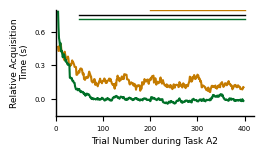

In [11]:
horizontal_bar_height = 0.75
f, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(65 * mm, 35 * mm))
for i, (color, session_str) in enumerate(zip(['#c47b00ff', '#007028ff'], [session1, session2])):
    t = fig5ac_delta_acq_df.xs(session_str).index.values
    assert len(t) == 400
    v = fig5ac_delta_acq_df.xs(session_str).values
    v = h.causal_smooth(v, window_size=25, window_function='box', nan_start=False)
    ax.plot(t[5:], v[5:], color=color, solid_capstyle='butt')
ax.plot([50,  400], [horizontal_bar_height, horizontal_bar_height], color='k', linestyle='-', linewidth=1)
ax.plot([200, 400], [horizontal_bar_height + 0.05, horizontal_bar_height + 0.05], color='#c47b00ff', linestyle='-', linewidth=1)
ax.plot([50,  400], [horizontal_bar_height - 0.03, horizontal_bar_height - 0.03], color='#007028ff', linestyle='-', linewidth=1)
h.set_tick_locations(np.arange(0, 405, 100), 'x', ax=ax)
h.set_tick_locations(np.arange(0, 2.1, 0.3), 'y', ax=ax)
h.set_tick_label_fontsize(both=10)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1)
ax.set_xlim([0, None])
ax.set_ylim([-0.15, 0.8])
ax.set_ylabel('Relative Acquisition\nTime (s)', fontsize=12)
ax.set_xlabel('Trial Number during Task A2',fontsize=12)
h.hide_spine('tr', ax=ax)
h.set_standard_fonts(ax)

## Figures 5b and 5c

Fig 5b p= 9.653197512714002e-08 n=176 targets

Fig 5d (better) p= 6.364152937976542e-08 n=48 targets
Fig 5d (wetter) p= 5.7328568934268685e-05 n=296 targets
Fig 5d (difference) p= 0.002543


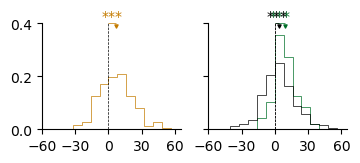

In [12]:
f, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(100 * mm, 35 * mm))

def plot_hist_outline(main_delta, main_color, bins, pval, ax, top_data_lim=0.4):   
    """
    Plots a histogram outline for a dataset, adds a significance bar with stars based on p-value, and customizes the plot appearance.

    Parameters:
    - main_delta (np.ndarray): The dataset to plot in the histogram.
    - main_color (str): Color for the histogram outline and other plot elements.
    - bins (np.ndarray or list): Bin edges for the histogram.
    - pval (float): P-value for annotating the plot with significance stars.
    - ax (matplotlib.axes.Axes): The matplotlib axes on which to plot.
    - top_data_lim (float, optional): The upper limit for data points and annotations on the y-axis. Defaults to 0.4.
    """
    vals, bins, _ = ax.hist(main_delta, color=main_color, bins=np.arange(-48, 65, 8), edgecolor=main_color, 
                            linewidth=0.5, histtype='step', weights=np.ones(len(main_delta)) / len(main_delta))
    h.hide_spine(ax=ax, tblr='tr')
    ax.set_xlim([-48, 65])
    ax.set_ylim([0, 0.4])
    h.plot_bar_with_stars(np.mean(main_delta), left_dist_mean=0, top_data_lim=0.4, pval=pval, ax=ax, color=main_color, linewidth=0.5)
    ax.axvline(0, color='k', linestyle='--', linewidth=0.5, solid_capstyle='butt')
    ax.scatter([np.nanmean(main_delta)], [0.39], color=main_color, marker='v', s=5)
    h.set_tick_locations(np.arange(-60, 65, 30), 'x', ax=ax)

bins = np.arange(-48, 65, 8) # histogram bins

# Figure 5b
fig5b_pval = scipy.stats.wilcoxon(long_session_mts).pvalue
print('Fig 5b', 'p=', fig5b_pval, f'n={len(long_session_mts)} targets\n')
plot_hist_outline(main_delta=long_session_mts, main_color='#c47b00ff', bins=bins, pval=fig5b_pval, ax=axes[0])

fig5d_pval_better = float(scipy.stats.wilcoxon(better_behavior_memory_trace_values).pvalue)
fig5d_pval_worse = float(scipy.stats.wilcoxon(worse_behavior_memory_trace_values).pvalue)

# Figure 5d
plot_hist_outline(main_delta=better_behavior_memory_trace_values, main_color='#007028ff', bins=bins, pval=fig5d_pval_better, ax=axes[1])
plot_hist_outline(main_delta=worse_behavior_memory_trace_values, main_color='k',          bins=bins, pval=fig5d_pval_worse, ax=axes[1])
print('Fig 5d', '(better) p=', fig5d_pval_better, f'n={len(better_behavior_memory_trace_values)} targets')
print('Fig 5d', '(wetter) p=', fig5d_pval_worse, f'n={len(worse_behavior_memory_trace_values)} targets')

pval_better_vs_worse = float(scipy.stats.ranksums(better_behavior_memory_trace_values, worse_behavior_memory_trace_values).pvalue)
print('Fig 5d (difference)', 'p=', np.round(pval_better_vs_worse, 6))

# Figure 6

In [13]:
# Load data for figure 6
fig6_session_str, fig6_tar, B_fam, B_new, fig6_df = h.load_pickle('./data/fig6')

In [14]:
# Key computations that go into decomposing the memory trace.
# Kept here instead of being relegated to the mt_funcion script for greater visibility/emphasis.

def calc_svd_udv(X, full_matrices=True):
    """
    Calculates the Singular Value Decomposition (SVD) of a matrix, and returns the decomposition matrices.

    Parameters:
    - X (np.ndarray): The matrix to decompose, where `X` is of size m x n.
    - full_matrices (bool, optional): If True, `U` and `V` are of shape m x m and n x n, respectively. If False, the shapes are reduced. Defaults to True.

    Returns:
    - U (np.ndarray): Left singular vectors, of shape m x m.
    - D (np.ndarray): Singular values matrix, of shape m x n.
    - V (np.ndarray): Right singular vectors (transposed), of shape n x n.

    Notes:
    - Ensures that the original matrix `X` can be reconstructed by `U @ D @ V.T` when `full_matrices` is True.
    - The singular values are returned in a diagonal matrix form.
    """
    U, D, VT = scipy.linalg.svd(X, full_matrices=full_matrices)  # (V transpose is returned)
    D = scipy.linalg.diagsvd(D, X.shape[0], X.shape[1])
    if full_matrices: assert np.allclose(X, U @ D @ VT)
    V = VT.T
    return U, D, V

def decompose_bci_map(B):
    """
    Decomposes a Brain-Computer Interface (BCI) map matrix into its row and null space components.

    Parameters:
    - B (np.ndarray): The BCI map matrix to decompose, expected to be of shape (2, 10).

    Returns:
    - R (np.ndarray): The row space component of `B`, of shape (10, 10).
    - N (np.ndarray): The null space component of `B`, of shape (10, 10).

    Notes:
    - Utilizes SVD to decompose `B` and then constructs the row and null space matrices from the right singular vectors.
    - The row space `R` is calculated using the first two right singular vectors, and the null space `N` uses the remaining vectors.
    - Ensures that `R` and `N` are orthogonal components representing the entire space.
    """
    if B.shape != (2, 10): raise ValueError()
    U, D, V = calc_svd_udv(B, full_matrices=True)
    Vr = V[:, :2] # 10x2
    assert Vr.shape == (10, 2)
    Vn = V[:, 2:] # 10x8
    assert Vn.shape == (10, 8)
    R = (Vr @ Vr.T) # shape 10x10
    N = (Vn @ Vn.T) # shape 10x10
    assert R.shape == (10, 10)
    assert N.shape == (10, 10)
    return R, N

def decompose_z(z, B):
    """
    Decomposes a vector `z` into its row and null components as determined by BCI map matrix B.

    Parameters:
    - z (np.ndarray): The vector to decompose.
    - B (np.ndarray): The BCI map matrix used for decomposition.

    Returns:
    - z_pot (np.ndarray): The component of `z` in the row space of B.
    - z_null (np.ndarray): The component of `z` in the null space of B.
    """
    R, N = decompose_bci_map(B)
    z_pot  = R @ z.T
    z_null = N @ z.T
    # Row space plus null space equals total space
    np.testing.assert_allclose(z_pot + z_null, z.T, atol=0.00001)
    return z_pot.T, z_null.T

# Demonstrating Memory Trace Calculations

In [15]:
z             = fig6_df[lat_names]    # Get our latent values. Shape number of timesteps by 10
z_pot, z_null = decompose_z(z, B_fam) # decompose the memory trace into its potent and null components
assert z.shape == z_pot.shape == z_null.shape # z_pot and z_null have the same shape as z

# Note that "potent" and "null" is always with respect to the Familiar Map. I.e. we are deconstructing
# neural activity into its potent and null components with respect to the Familiar map, then projecting
# these components onto the New Map. See the methods section of the manuscript for details.

z_full_vel = z @ B_new.T       # get the full velocity
z_pot_vel  = z_pot  @ B_new.T  # get the velocity due to the potent component of the New Map
z_null_vel = z_null @ B_new.T  # get the velocity due to the null   component of the New Map

# The full velocity is the sum of the velocity due to the potent and null components.
assert np.allclose(z_full_vel, z_pot_vel + z_null_vel)

# Get the cursor-target vectors. "Prev" means that it is before the velocity from current timestep has been applied
# to update the cursor position
cursor_target_vectors = fig6_df[['c2t_vectX_prev', 'c2t_vectY_prev']].values
# Calculate the angular error magnitude for the full velocity.
angular_error = np.abs(h.calc_angle_between180(z_full_vel.values, cursor_target_vectors))

# Convert our velocities into progress.
z_full_prog = (z_full_vel * cursor_target_vectors).sum(axis=1)
z_pot_prog  = (z_pot_vel  * cursor_target_vectors).sum(axis=1)
z_null_prog = (z_null_vel * cursor_target_vectors).sum(axis=1)
fig6_df = fig6_df.assign(**{'full_prog': z_full_prog, 'pot_prog': z_pot_prog, 'null_prog': z_null_prog, 
                           'angular_error': angular_error})

# Average progress and angular error based on task
fig6_means = fig6_df.groupby('block_type').mean()

# Computing learning values and memory trace values due to the various components.
learning            = fig6_means.xs('NewTask')['full_prog'] - fig6_means.xs('FamTask1')['full_prog']
full_memory_trace   = fig6_means.xs('FamTask2')['full_prog'] - fig6_means.xs('FamTask1')['full_prog']
potent_memory_trace = fig6_means.xs('FamTask2')['pot_prog']  - fig6_means.xs('FamTask1')['pot_prog']
null_memory_trace   = fig6_means.xs('FamTask2')['null_prog'] - fig6_means.xs('FamTask1')['null_prog']

# Higher progress is "better", while lower absolute angular error is better.
# Thus we will flip the sign on the absolute angular error so that a higher value is better 
# (meaning less error during Familiar Task 2, relative to Familiar Task 1)
ang_error_memory_trace   = - (fig6_means.xs('FamTask2')['angular_error'] - fig6_means.xs('FamTask1')['angular_error'])
assert np.allclose(full_memory_trace, null_memory_trace + potent_memory_trace)

# Print out everything we have calculated.
print('Memory Trace:\t\t\t\t\t\t', np.round(full_memory_trace, 3), 'mm/s')
print('Memory Trace due to Potent-to-Familiar-Map component:\t', np.round(potent_memory_trace, 3), 'mm/s')
print('Memory Trace due to Null-to-Familiar-Map component:\t', np.round(null_memory_trace, 3), 'mm/s')
print('Memory Trace measured using angular error :\t\t', np.round(ang_error_memory_trace, 3), 'degrees')
print('Amount of Learning:\t\t\t\t\t', np.round(learning, 3), 'mm/s')

Memory Trace:						 10.636 mm/s
Memory Trace due to Potent-to-Familiar-Map component:	 0.403 mm/s
Memory Trace due to Null-to-Familiar-Map component:	 10.232 mm/s
Memory Trace measured using angular error :		 13.314 degrees
Amount of Learning:					 49.825 mm/s


## Principal Angle Calculation
An example of how the principal angle was calculated in Figure S6b

In [16]:
# Calculate the principal angle between the Familiar Map and the New Map
p2, p1 = np.rad2deg(scipy.linalg.subspace_angles(B_fam.T, B_new.T))
print(f'\nFirst Principal Angle between BCI Maps:\t {np.round(p1, 2)} degrees')
print(f'Second Principal Angle between BCI Maps: {np.round(p2, 2)} degrees')


First Principal Angle between BCI Maps:	 62.45 degrees
Second Principal Angle between BCI Maps: 82.71 degrees


## Columns of "B" matrix
Figure S1a and S1b

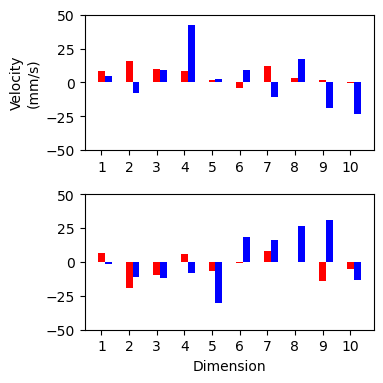

In [17]:
f, axes = plt.subplots(2, 1, figsize=(100 * mm, 100 * mm), sharex=True, sharey=True)
width = 0.25
axes[0].bar(np.arange(1, 11), B_fam[0, :], width=width, color='r')
axes[0].bar(np.arange(1, 11) + width, B_new[0, :], width=width, color='b')
h.set_tick_locations(np.arange(1, 11), 'x')
h.show_tick_labels('xy', ax=axes[0])
axes[1].set_ylim([-50, 50])
axes[1].bar(np.arange(1, 11), B_fam[1, :], width=width, color='r')
axes[1].bar(np.arange(1, 11) + width, B_new[1, :], width=width, color='b')
axes[1].set_xlabel('Dimension')
axes[0].set_ylabel('Velocity\n(mm/s)')
plt.tight_layout()

# Figure 7

In [18]:
# Load data for figure 7
fig7_session_str, fig7_tar, fig7_session_df = h.load_pickle('./data/fig7')

In [19]:
# Calculate the means activity patterns for Figure 7
control_block_types = h.permute_subset(fig7_session_df.block_type.values, ['FamTask1', 'FamTask2'], copy_x=True)
fig7_session_df     = fig7_session_df.assign(fig7_ctrl_block_types = control_block_types)
control_block_means = fig7_session_df.groupby(control_block_types)[lat_names].mean()
session_block_means = fig7_session_df.groupby('block_type')[lat_names].mean()

In [20]:
def calc_path_angle(block_means):
    """ Calculates difference between the path of washout and the path of learning"""
    learn_path = block_means.xs('NewTask') - block_means.xs('FamTask1')
    learn_path = learn_path / np.linalg.norm(learn_path)
    wash_path  = block_means.xs('FamTask2') - block_means.xs('NewTask')
    wash_path  = wash_path / np.linalg.norm(wash_path)
    return np.round(np.rad2deg(np.arccos(np.dot(learn_path, wash_path))), 2)
print('Angle between path of learning and path of washout:\t\t', calc_path_angle(session_block_means), 'degrees')
print('Angle between path of learning and path of washout (control):\t', calc_path_angle(control_block_means), 'degrees')

Angle between path of learning and path of washout:		 156.58 degrees
Angle between path of learning and path of washout (control):	 177.03 degrees


# Memory trace per trial
Figure S5a

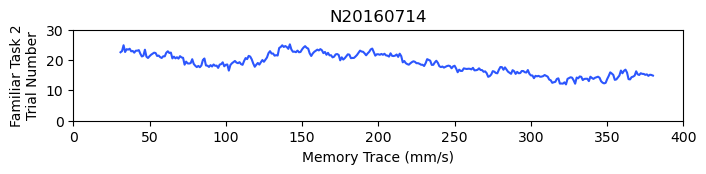

In [21]:
block_trial_index, mt_per_trial = h.load_pickle('./data/mt_per_trial')
f, ax = plt.subplots(1, 1, figsize=(200 * mm, 30 * mm))
index, mt_per_trial_smoothed = h.center_smooth(block_trial_index, mt_per_trial, 40)
ax.plot(index[50:], mt_per_trial_smoothed[50:], color=np.array([0.17256963, 0.33646602, 0.99096435]))
ax.set_xlim([0, 400])
ax.set_ylim([0, 30])
ax.set_ylabel('Familiar Task 2\nTrial Number')
ax.set_title(session_str)
_ = ax.set_xlabel('Memory Trace (mm/s)')

# Single Neuron Analyses

In [22]:
# Load data for the single neuron analyses (Figures S)
spike_pd, spike_names = h.load_pickle('./data/single_neuron')

## Subpopulation Rank Order Scattter

n =  89 neurons
p =  8.402916821382265e-33


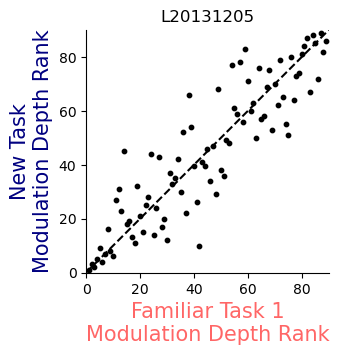

In [23]:
mean_firing = spike_pd.groupby(['block_type', 'tar']).mean()
def calc_modulation_depth_rank(mean_firing, block_type):
    return (mean_firing.xs(block_type).max() - mean_firing.xs(block_type).min()).rank(ascending=False)
modulation_depth_rank_FamTask1 = calc_modulation_depth_rank(mean_firing, block_type='FamTask1')
modulation_depth_rank_NewTask  = calc_modulation_depth_rank(mean_firing, block_type='NewTask')
modulation_depth_rank_FamTask2 = calc_modulation_depth_rank(mean_firing, block_type='FamTask2')
# This p-value will tell you whether there is statistically significant evidence to suggest that the model with your predictor x fits the data better than a model with no predictors (i.e., a model that only includes the intercept).
_, pval = h.univariate_ftest(modulation_depth_rank_FamTask1, modulation_depth_rank_NewTask, p2=2)

print('n = ', len(modulation_depth_rank_FamTask1), 'neurons')
print('p = ', pval)
f, ax = plt.subplots(1, 1, figsize=(80 * mm, 80 * mm), sharex=True, sharey=True)
x, y = modulation_depth_rank_FamTask1, modulation_depth_rank_NewTask
ax.scatter(x, y, color='k', s=10)
ax.set_xlabel('Familiar Task 1\nModulation Depth Rank', color=h.block_type_to_color('FamTask1'))
ax.set_ylabel('New Task\nModulation Depth Rank',color=h.block_type_to_color('NewTask'))
slope, intercept, rval, _, stderr = scipy.stats.linregress(x, y)
_, pval = h.univariate_ftest(x, y, p2=2)
assert len(x) == len(y)
assert min(x) == 1 # 1 is the minimum rank
ax.set_aspect('equal')
h.set_standard_fonts(ax, ticksize=10, labelsize=15)
h.hide_spine('tr', ax=ax)
ax.axline([0, 0], [1, 1], color='k', linestyle='--')
ax.set_title('L20131205')
ax.set_xlim([0, len(x) + 1])
_ = ax.set_ylim([0, len(x) + 1])

## Change in Preferred Direction
Figure S3c

In [24]:
def compute_change_in_pd(neuron, thetas, block_types):
    flags1 = block_types == 'FamTask1'
    flags2 = block_types == 'FamTask2'
    _, _, pref_dir_1, _ = h.fit_cosine_tuning_curve(neuron[flags1], np.deg2rad(thetas[flags1]))
    _, _, pref_dir_2, _ = h.fit_cosine_tuning_curve(neuron[flags2], np.deg2rad(thetas[flags2]))
    return np.rad2deg(np.abs(pref_dir_2 - pref_dir_1) % (np.pi))
neuron_spike_counts = spike_pd[spike_names].values[:, 37]
thetas = spike_pd.c2t_angle_prev.values
ctrl_block_types = h.permute_subset(spike_pd.block_type.values, ['FamTask1', 'FamTask2'])
data_change = compute_change_in_pd(neuron_spike_counts, thetas, spike_pd.block_type.values)
ctrl_change = compute_change_in_pd(neuron_spike_counts, thetas, ctrl_block_types)
print('Change in PD between Familiar Tasks 1 and 2:\t\t', np.round(data_change, 2), 'degrees')
print('Change in PD between Familiar Tasks 1 and 2 (control):\t', np.round(ctrl_change, 2), 'degrees')

Change in PD between Familiar Tasks 1 and 2:		 61.71 degrees
Change in PD between Familiar Tasks 1 and 2 (control):	 8.66 degrees


## Single Neuron Example
Figure S3

In [25]:
neuron_spike_counts = spike_pd[spike_names].values[:, 37]
thetas              = np.deg2rad(spike_pd.c2t_angle_prev.values)
block_types         = spike_pd.block_type
y_hats = collections.defaultdict(list)
x_rads = np.linspace(0, 1.99999 * np.pi, 50)
x_degs = np.rad2deg(x_rads)
num_permutations = 500
for block_type in ['FamTask1', 'NewTask', 'FamTask2']:
    flags = block_types == block_type
    block_spike_counts = neuron_spike_counts[flags]
    block_thetas       = thetas[flags]
    assert len(block_thetas) == len(block_spike_counts)
    for i in range(num_permutations):
        idxs = random.choices(range(len(block_thetas)), k=len(block_thetas))
        baseline_fr_ci, max_fr_ci, pref_dir_ci, _ = h.fit_cosine_tuning_curve(block_spike_counts[idxs], block_thetas[idxs])
        y_ci = h.cosine_tune_fn(angles=x_rads, baseline_fr=baseline_fr_ci, max_fr=max_fr_ci, pref_dir=pref_dir_ci) / 0.045
        y_hats[block_type].append(y_ci)

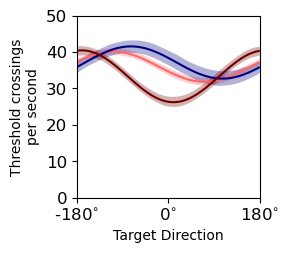

In [26]:
def plot_confidence_intervals(ax, x_deg, y_hats, num_permutations):
    """
    Plots confidence intervals for different task types on a given axis.

    Parameters:
    - ax (matplotlib.axes.Axes): The axes on which to plot the confidence intervals.
    - x_deg (np.ndarray): The x-values in degrees for the plot.
    - y_hats (dict): A dictionary containing arrays of predictions for each task type ('FamTask1', 'NewTask', 'FamTask2').
    - num_permutations (int): The number of permutations used to calculate the confidence intervals.

    Notes:
    - For each block type, sorts the y-values and selects the 2.5th and 97.5th percentiles as the lower and upper bounds of the confidence interval.
    - Fills the area between these bounds with the color associated with the block type, with a slight transparency.
    """
    for block_type in ['FamTask1', 'NewTask', 'FamTask2']:
        y_hat_arr = np.asarray(y_hats[block_type])
        y_hat_arr.sort(axis=0)
        ax.fill_between(x_deg,
                        y_hat_arr[int(num_permutations * 0.025)],
                        y_hat_arr[int(num_permutations * 0.975)],
                        facecolor=h.task_to_color(block_type), alpha=0.3)

def plot_tuning_curves(ax, x_rads, neuron_spike_counts):
    """
    Plots tuning curves for neurons based on their response to different stimulus directions.

    Parameters:
    - ax (matplotlib.axes.Axes): The axes on which to plot the tuning curves.
    - x_rads (np.ndarray): The stimulus directions in radians for which the tuning curves are to be plotted.
    - neuron_spike_counts (np.ndarray): The spike counts for neurons across different trials or stimulus conditions.

    Notes:
    - Iterates over different block types ('FamTask1', 'NewTask', 'FamTask2') and filters the spike counts and stimulus directions accordingly.
    - Fits a cosine tuning curve to the spike counts for each block type, obtaining parameters such as baseline firing rate, maximum firing rate, and preferred direction.
    - Converts the radians to degrees for plotting and scales the tuning curve by a constant factor (e.g., 0.045) to match desired units or normalization.
    - Plots the tuning curves using the color associated with each block type.
    """
    for block_type in ['FamTask1', 'NewTask', 'FamTask2']:
        flags = block_types == block_type
        block_spike_counts = neuron_spike_counts[flags]
        block_thetas       = thetas[flags]
        baseline_fr, max_fr, pref_dir, _ = h.fit_cosine_tuning_curve(block_spike_counts, block_thetas)
        y = h.cosine_tune_fn(angles=x_rads, baseline_fr=baseline_fr, max_fr=max_fr, pref_dir=pref_dir) / 0.045
        ax.plot(np.rad2deg(x_rads), y, color=h.task_to_color(block_type), solid_capstyle='butt')
    
f, ax = plt.subplots(1, 1, figsize=(60 * mm, 60 * mm))
plot_confidence_intervals(ax, np.rad2deg(x_rads), y_hats, num_permutations)
plot_tuning_curves(ax, x_rads, neuron_spike_counts)
h.set_tick_locations([0, 180, 360], 'x', ax=ax)
h.set_tick_labels(['-180$^{\circ}$', '0$^{\circ}$', '$180^{\circ}$'], 'x')
h.set_tick_label_fontsize(12)
ax.set_xlim(0, 360)
ax.set_ylim(0, 50)
ax.set_xlabel('Target Direction')
_ = ax.set_ylabel('Threshold crossings\nper second')